In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
df = pd.read_csv('Algerian_forest_fires_cleaned.csv')
df.head(5)

,day,month,year,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi,classes,region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


In [3]:
# Drop the date columns
df.drop(columns=['day', 'month', 'year'], inplace=True)
df.head(2)

,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi,classes,region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0


In [4]:
# Convert class to numeric values
df['classes'] = df['classes'].replace({'fire': 1, 'not fire': 0})
df['classes'].value_counts()

classes
1    137
0    106
Name: count, dtype: int64

In [5]:
# Split the dataset into features and target variable
X = df.drop(columns=['classes'])
y = df['classes']

Text(0.5, 1.0, 'Correlation Matrix')

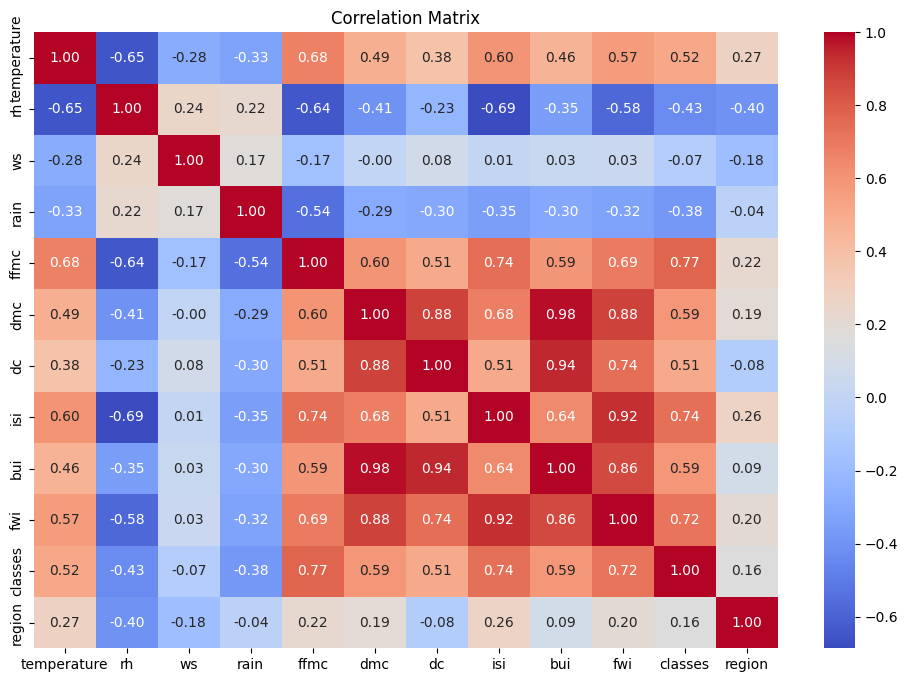

In [6]:
# Handle multicollinearity
plt.figure(figsize=(12, 8)) 
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')

In [7]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Identify features with high correlation
threshold = 0.8
collinear_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            collinear_features.add(correlation_matrix.columns[i])

print("Collinear features:", collinear_features)

Collinear features: {'dc', 'bui', 'fwi'}


In [8]:
# Drop collinear features
X = X.drop(columns=collinear_features)
print(f"Dropped features: {collinear_features}")

Dropped features: {'dc', 'bui', 'fwi'}


In [9]:
# Balance the dataset using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [10]:
# Confirm oversampling
print(f"Original dataset shape: {X.shape}, {y.shape}")
print(f"Resampled dataset shape: {X_resampled.shape}, {y_resampled.shape}")

Original dataset shape: (243, 8), (243,)
Resampled dataset shape: (274, 8), (274,)


In [11]:
#Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [12]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()
# Fit the scaler to the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [14]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

In [15]:
# Initialize an empty DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Loop through each model, fit it, and evaluate its performance
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    f1_score = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    
    # Create a temporary DataFrame for the current model's results
    temp_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1_score]
    })
    
    # Concatenate the temporary DataFrame with the results DataFrame
    results = pd.concat([results, temp_df], ignore_index=True)

# Display the results
results = results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
results

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,1.000000,1.000000,1.000000,1.000000
1,AdaBoost,0.981818,0.967742,1.000000,0.983607
2,Gradient Boosting,0.981818,0.967742,1.000000,0.983607
3,Naive Bayes,0.963636,0.937500,1.000000,0.967742
4,Decision Tree,0.945455,0.935484,0.966667,0.950820
5,SVM,0.945455,1.000000,0.900000,0.947368
6,Logistic Regression,0.927273,0.964286,0.900000,0.931034
7,KNN,0.909091,0.903226,0.933333,0.918033


In [16]:
#Using cross validation
from sklearn.model_selection import cross_val_score

# Initialize an empty DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Mean Accuracy', 'Std Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1-Score'])

# Loop through each model, perform cross-validation, and evaluate its performance
for model_name, model in models.items():
    accuracy = cross_val_score(model, X, y, cv=15, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=15, scoring='precision')
    recall = cross_val_score(model, X, y, cv=15, scoring='recall')
    f1_score = cross_val_score(model, X, y, cv=15, scoring='f1')
    
    # Create a temporary DataFrame for the current model's results
    temp_df = pd.DataFrame({
        'Model': [model_name],
        'Mean Accuracy': [accuracy.mean()],
        'Std Accuracy': [accuracy.std()],
        'Mean Precision': [precision.mean()],
        'Mean Recall': [recall.mean()],
        'Mean F1-Score': [f1_score.mean()]
    })
    
    # Concatenate the temporary DataFrame with the results DataFrame
    results = pd.concat([results, temp_df], ignore_index=True)

# Display the results
results = results.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
results

,Model,Mean Accuracy,Std Accuracy,Mean Precision,Mean Recall,Mean F1-Score
0,Gradient Boosting,0.983824,0.035233,0.987879,0.985926,0.985903
1,AdaBoost,0.983824,0.035233,0.987879,0.985926,0.985903
2,Decision Tree,0.979412,0.037004,0.987879,0.977778,0.981569
3,Random Forest,0.971078,0.038439,0.981212,0.970370,0.974138
4,Logistic Regression,0.958824,0.043484,0.978519,0.948889,0.962481
5,SVM,0.942647,0.065006,0.923706,0.992593,0.953999
6,Naive Bayes,0.942402,0.069765,0.946503,0.955556,0.948338
7,KNN,0.905392,0.092264,0.905519,0.940741,0.918641


In [17]:
# Saving the best model
import pickle
pickle.dump(models['Random Forest'], open('forest_fire_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))